In [1]:
import pickle
from typing import Optional
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from gurobipy import GRB
from plots import *
from ems_data import *
from simulation import *
from neural_network import *
from mip_models import *

TRAINING_METRICS = ['coverage_9min', 'coverage_15min', 'survival_rate', 'response_time_mean', 'response_time_median', 'response_time_90th_percentile']
FACILITY_CAPACITY = 4
TIME_LIMIT = 600
SUCCESS_PROB = 0.8

def plot_metric(X: np.ndarray, y: np.ndarray, metric: str, metric_short: Optional[str] = None):
    """Plot histogram and box plots side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    fig.suptitle(metric)
    if metric_short is not None:
        metric = metric_short
    ax[0].hist(y, bins=100)
    ax[0].set_xlabel(metric)
    ax[0].set_ylabel("Frequency")
    plot_metric_by_ambulance_count(X, y, metric, ax=ax[1])
    return fig, ax

def best_solution_from_dataset(dataset: pd.DataFrame, n_ambulances: int, metric: str) -> tuple[pd.Series, pd.Series]:
    """Finds the best solution w.r.t. a metric for a given maximum number of ambulances."""
    X = dataset.drop(columns=METRICS)
    Y = dataset[METRICS]
    indices = np.where(X.sum(axis=1) <= n_ambulances)[0]
    argmin_or_argmax = np.argmin if 'response_time' in metric else np.argmax
    y = Y[metric]
    best_idx = indices[argmin_or_argmax(y[indices])]
    return X.iloc[best_idx], Y.iloc[best_idx]

def remove_outliers_at_each_ambulance_count(X, y, k=1.5):
    """For each total number of ambulances, isolate samples with that total and remove outliers.

    Parameters
    ----------
    X, y : np.ndarray
        The dataset.
    
    k : float
        y values outside the range [Q1 - k*IQR, Q3 + k*IQR] are considered outliers.
    
    Returns
    -------
    X_new, y_new : np.ndarray
        The dataset with outliers removed.
    """
    X_sum = X.sum(axis=1)
    min_ambulances = X_sum.min()
    max_ambulances = X_sum.max()
    keep = np.full(X.shape[0], False)
    for total in range(min_ambulances, max_ambulances+1):
        y_subset = y[X_sum == total]
        q1 = np.percentile(y_subset, 25)
        q3 = np.percentile(y_subset, 75)
        iqr = q3 - q1
        keep |= (
            (X_sum == total)
            & (y >= q1 - k*iqr)
            & (y <= q3 + k*iqr)
        )
    return X[keep], y[keep]

def rescale(x: np.ndarray, min: float = 0, max: float = 1) -> np.ndarray:
    """Shift and scale data to the range [min, max]."""
    return (x - x.min()) / (x.max() - x.min()) * (max - min) + min

print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

# stations: 17
# demand nodes: 440


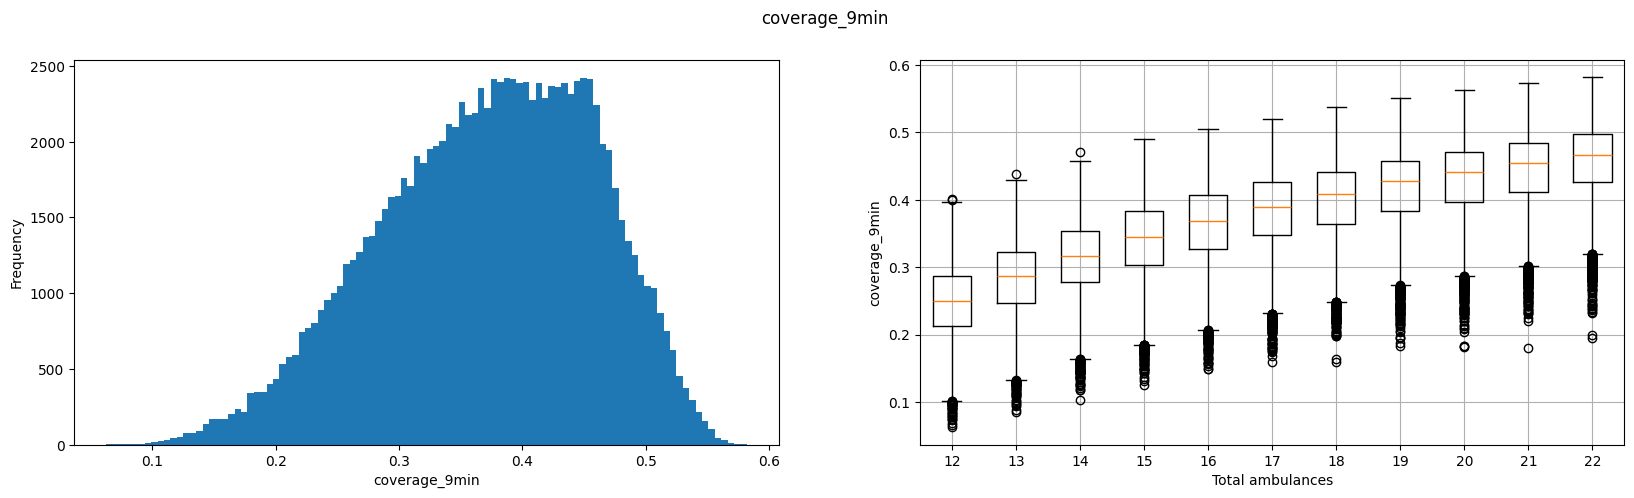

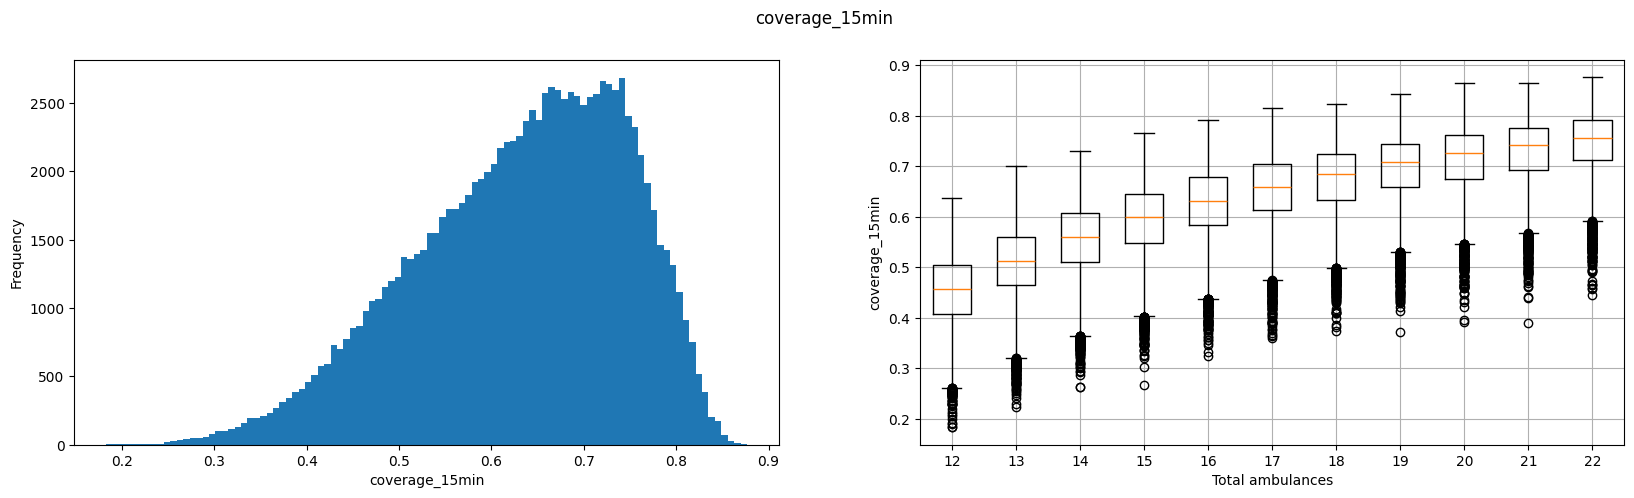

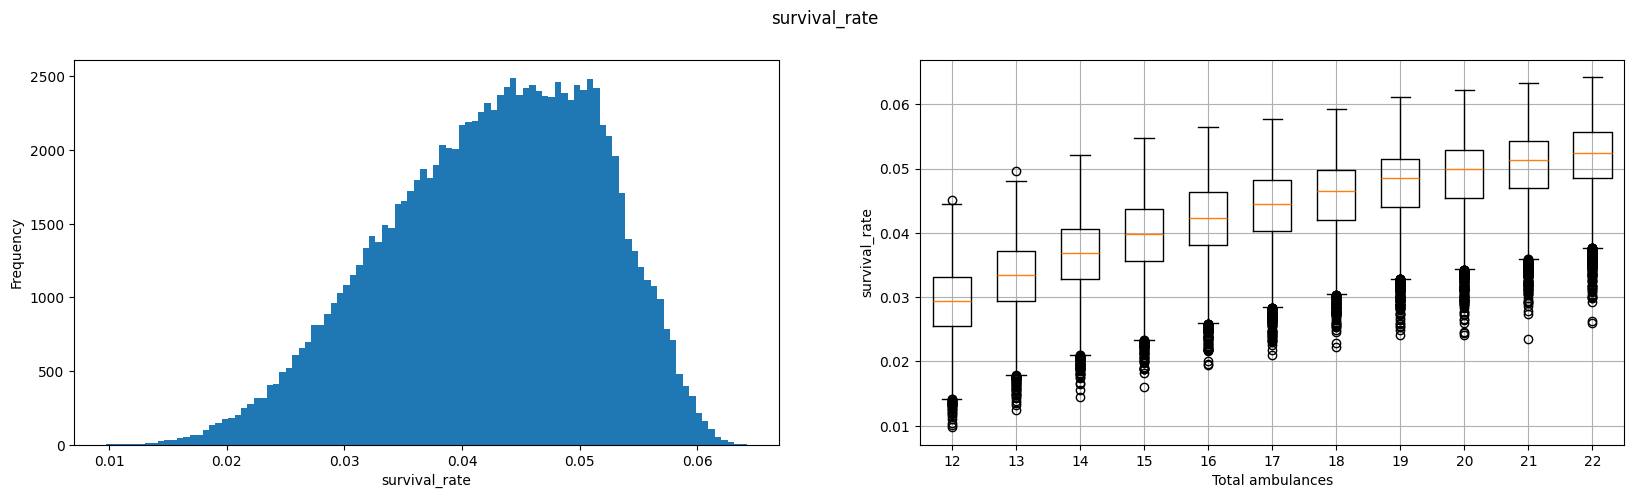

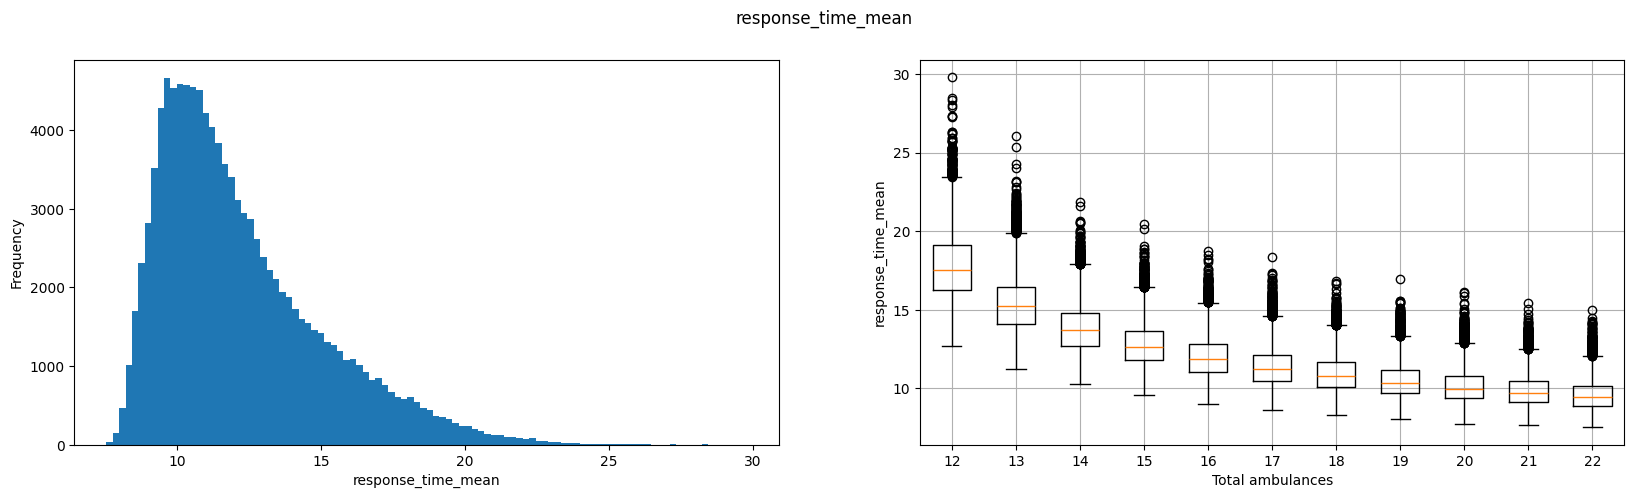

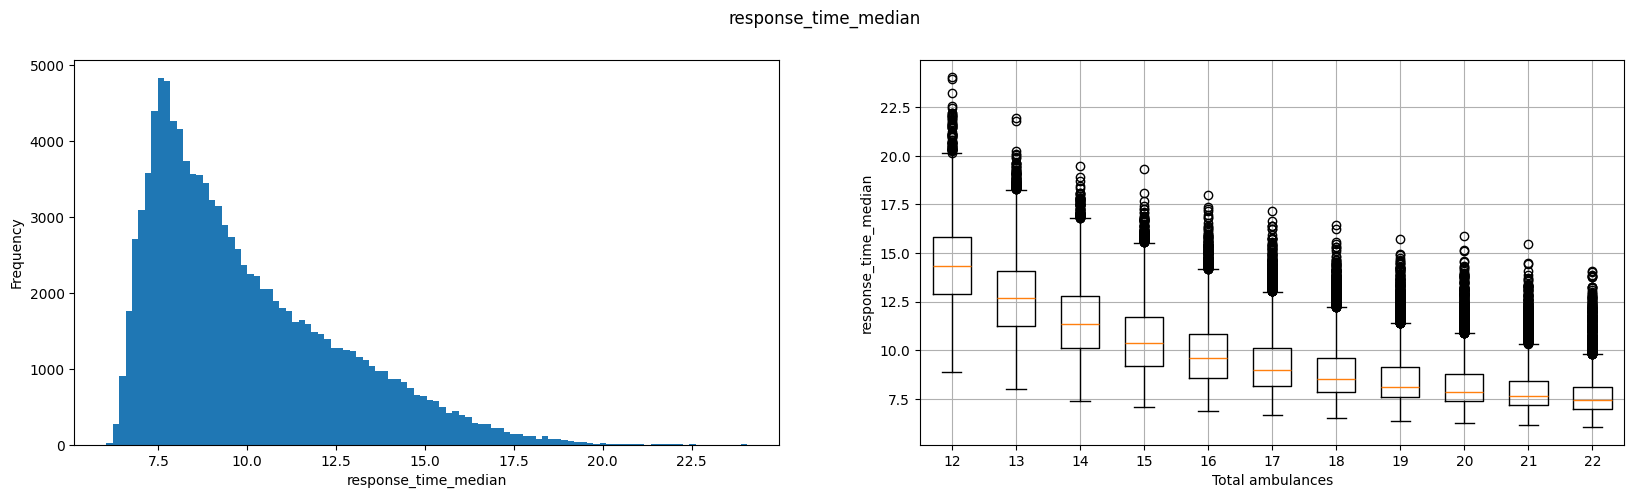

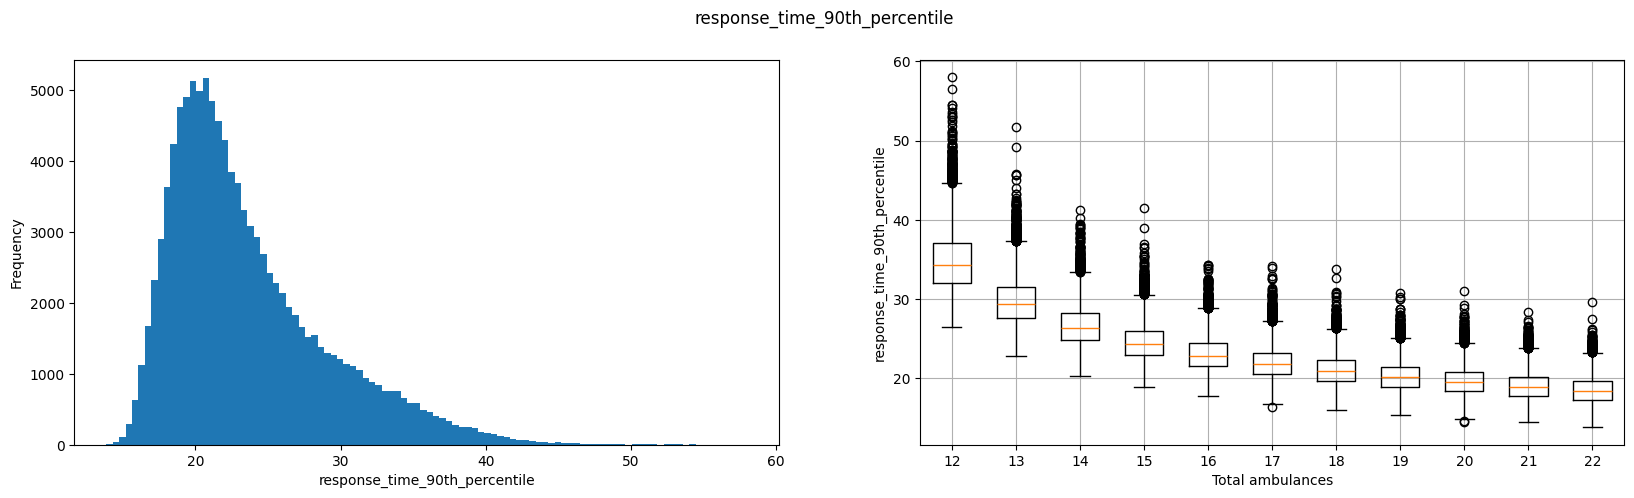

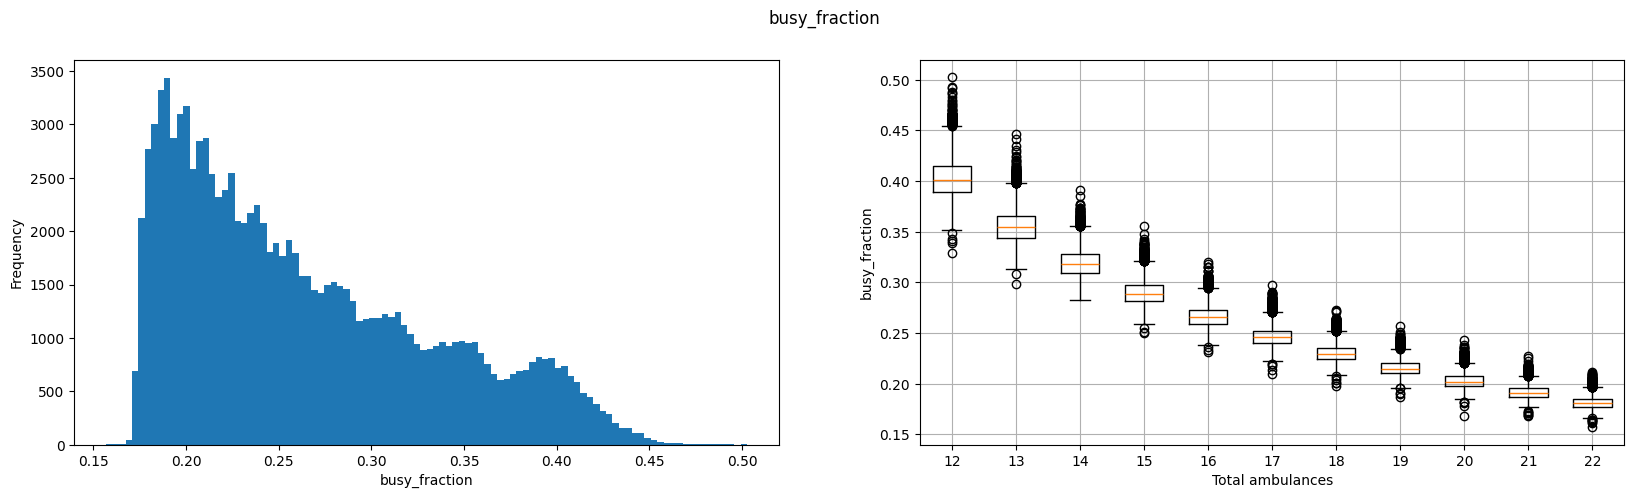

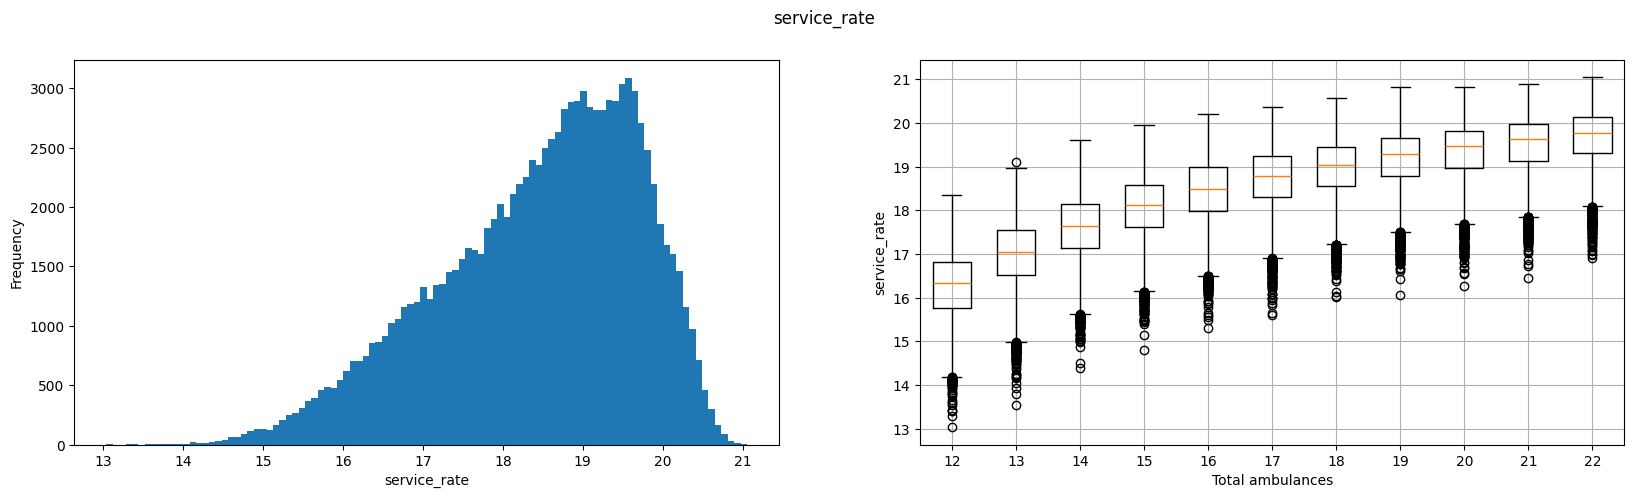

In [2]:
N_AMBULANCES = 17  # 14, 17, 20

region_id = 3
with open('ems_data.pkl', 'rb') as f:
    ems_data = pickle.load(f)
ems_data.region_id = region_id
demand_nodes = EMSData.read_patient_locations(region_id, test_id=0)
n_stations = len(ems_data.stations)
n_demand_nodes = len(demand_nodes)
print(f"# stations: {n_stations}")
print(f"# demand nodes: {n_demand_nodes}")
distance = Simulation.driving_distance(demand_nodes, ems_data.stations)
sim = Simulation(ems_data, n_days=100, n_replications=5)

dataset = pd.read_csv(f'dataset{region_id}.csv')
X = dataset.drop(columns=METRICS).to_numpy()
Y = dataset[METRICS].to_numpy()

for metric in METRICS:
    y = Y[:, METRICS.index(metric)]
    plot_metric(X, y, metric)

In [3]:
# Estimate busy_fraction and service_rate
BUSY_FRACTION = {}
SERVICE_RATE = {}
for n_ambulances in [14, 17, 20]:
    # Busy fraction used by MEXCLP so estimate using best w.r.t. coverage_15min
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'coverage_15min')
    BUSY_FRACTION[n_ambulances] = y['busy_fraction']
    # Service rate used by p-median + queueing model so estimate using best w.r.t. response_time_mean
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'response_time_mean')
    SERVICE_RATE[n_ambulances] = y['service_rate']
print(f"BUSY_FRACTION = {BUSY_FRACTION}\nSERVICE_RATE = {SERVICE_RATE}")

BUSY_FRACTION = {14: 0.288004162638955, 17: 0.2288075320373579, 20: 0.1880189046214391}
SERVICE_RATE = {14: 19.377337143021244, 17: 20.266597902930563, 20: 20.77655572881174}


# Coverage

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Coverage (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Coverage (transformed)'>],
       dtype=object))

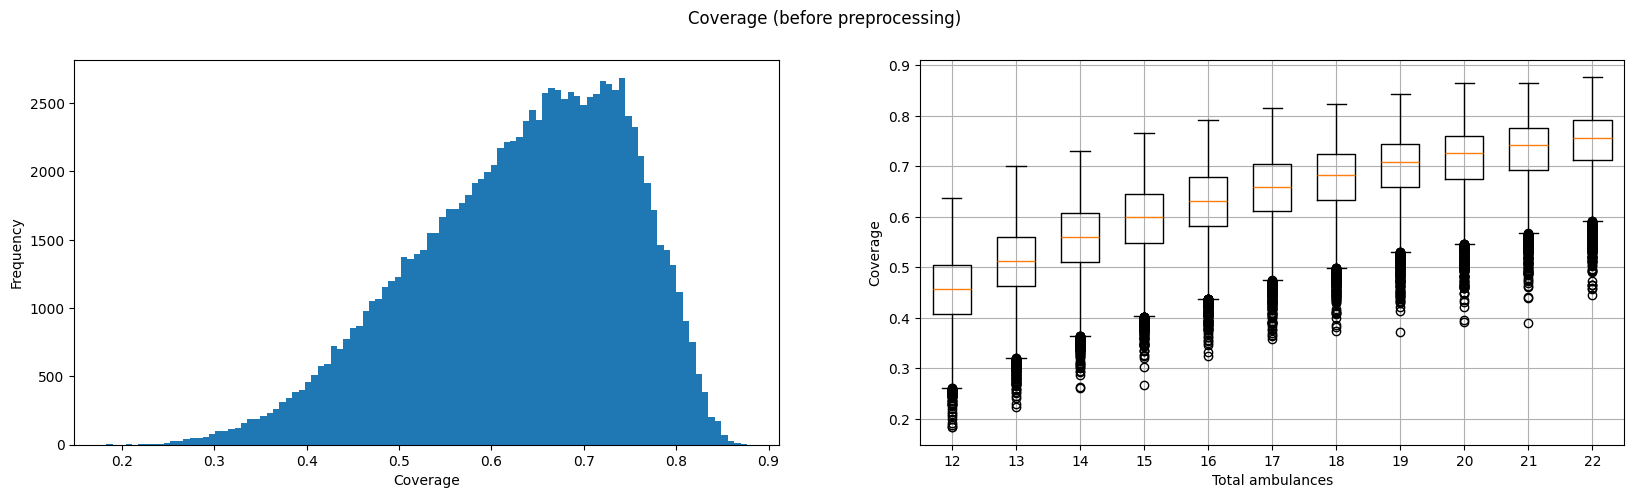

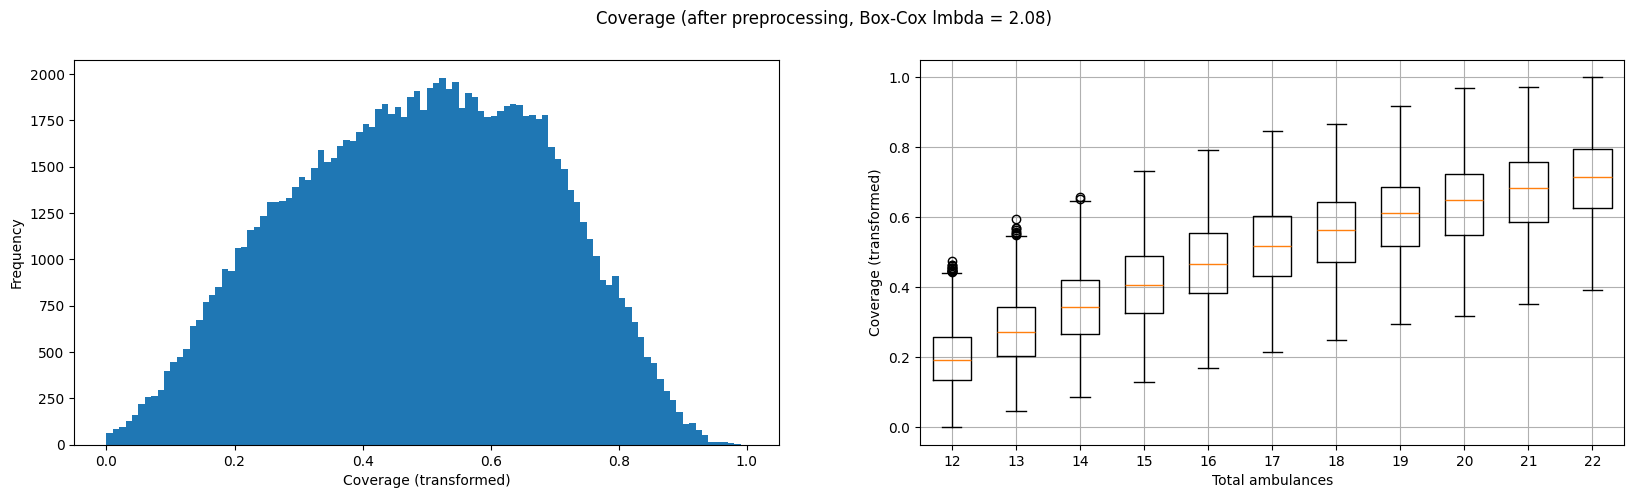

In [4]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.coverage_15min.to_numpy()
plot_metric(X, y, "Coverage (before preprocessing)", "Coverage")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Coverage (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Coverage (transformed)")

In [5]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='simcoe_coverage'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 81%|████████  | 81/100 [02:35<00:36,  1.92s/epoch, best_val_loss=0.00015, train_loss=0.000695, val_loss=0.000338] 


Early stopping


 32%|███▏      | 32/100 [01:01<02:10,  1.91s/epoch, best_val_loss=4.21e-5, train_loss=4.3e-5, val_loss=4.91e-5]  


Early stopping


100%|██████████| 100/100 [02:46<00:00,  1.66s/epoch, best_val_loss=3.26e-5, train_loss=3.18e-5, val_loss=3.26e-5]


In [6]:
weights, biases = MLP.load_npz('simcoe_coverage.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-17
Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4024 rows, 3036 columns and 26058 nonzeros
Model fingerprint: 0x3b77319a
Variable types: 2019 continuous, 1017 integer (1000 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 50 rows and 43 columns
Presolve time: 0.09s
Presolved: 3974 rows, 2993 columns, 26236 nonzeros
Variable types: 1984 continuous, 1009 integer (992 binary)

Root relaxation: objective 3.073904e+00, 1304 iterations, 0.10 seconds (0.23 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl U

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.547090,0.838055,0.060193,8.237178,6.400838,15.753800,0.220917,20.858112
1,0.548629,0.839259,0.060154,8.267127,6.402901,15.778638,0.224553,20.629963
2,0.547537,0.830326,0.059903,8.341236,6.367949,16.209201,0.221284,20.763546
3,0.542489,0.834172,0.060749,8.221210,6.394394,15.882042,0.219200,20.803694
4,0.550734,0.839943,0.060741,8.164758,6.350903,15.647123,0.219588,20.796952


In [7]:
results.mean()

coverage_9min                     0.547296
coverage_15min                    0.836351
survival_rate                     0.060348
response_time_mean                8.246302
response_time_median              6.383397
response_time_90th_percentile    15.854161
busy_fraction                     0.221108
service_rate                     20.770453
dtype: float64

# Survival

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Survival rate (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Survival rate (transformed)'>],
       dtype=object))

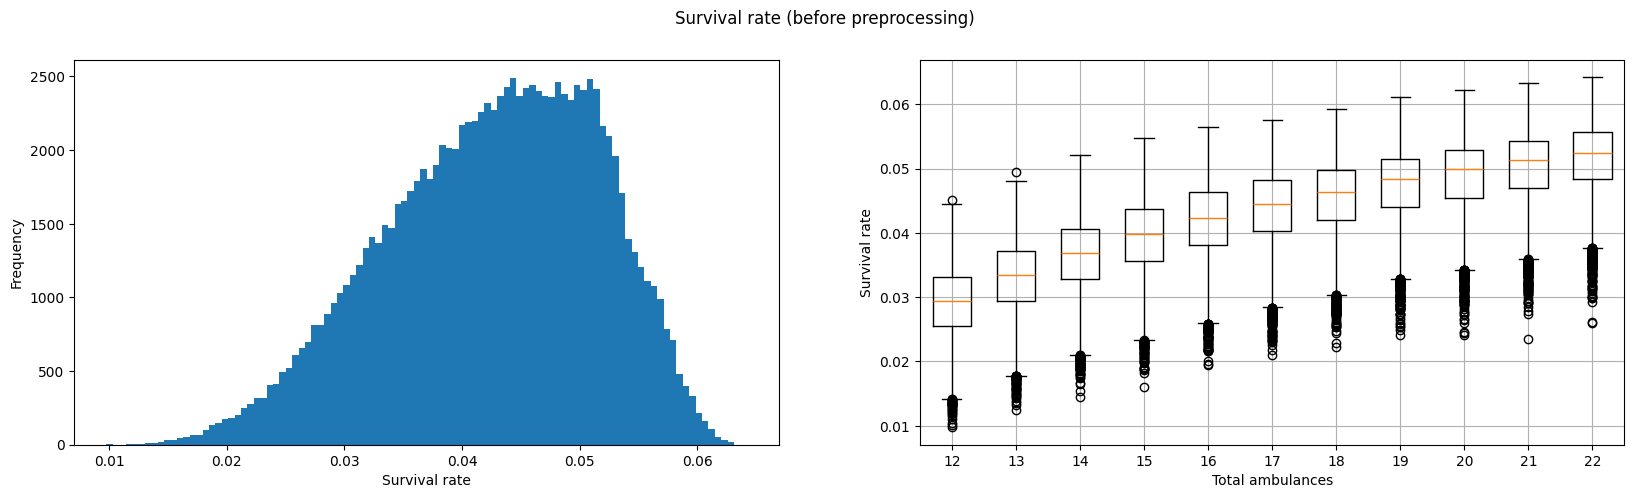

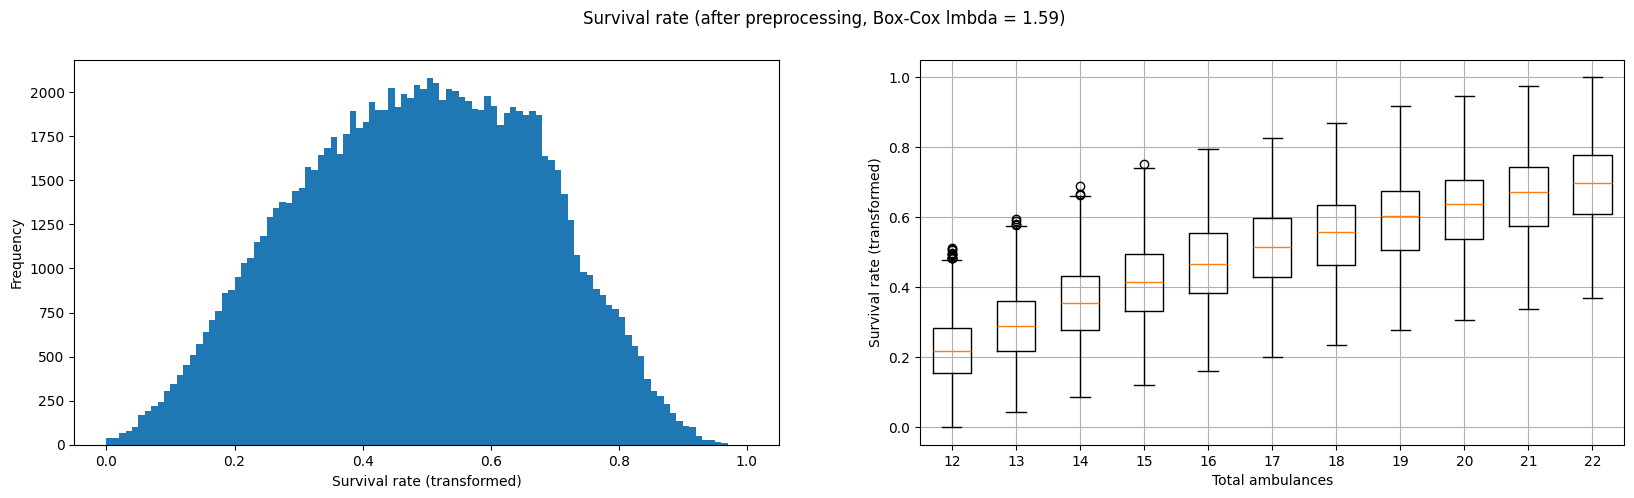

In [8]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.survival_rate.to_numpy()
plot_metric(X, y, "Survival rate (before preprocessing)", "Survival rate")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Survival rate (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Survival rate (transformed)")

In [9]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='simcoe_survival'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 54%|█████▍    | 54/100 [01:44<01:29,  1.94s/epoch, best_val_loss=0.000136, train_loss=0.000579, val_loss=0.000157]


Early stopping


 91%|█████████ | 91/100 [02:51<00:16,  1.89s/epoch, best_val_loss=4.2e-5, train_loss=4.4e-5, val_loss=4.24e-5]  


Early stopping


100%|██████████| 100/100 [02:48<00:00,  1.68s/epoch, best_val_loss=3.47e-5, train_loss=3.41e-5, val_loss=3.47e-5]


In [10]:
weights, biases = MLP.load_npz('simcoe_survival.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4020 rows, 3036 columns and 26054 nonzeros
Model fingerprint: 0x9382deb3
Variable types: 2019 continuous, 1017 integer (1000 binary)
Coefficient statistics:
  Matrix range     [4e-06, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e-04, 2e+01]
Presolve removed 61 rows and 59 columns
Presolve time: 0.11s
Presolved: 3959 rows, 2977 columns, 26939 nonzeros
Variable types: 1974 continuous, 1003 integer (986 binary)

Root relaxation: objective 3.952095e+00, 1353 iterations, 0.07 seconds (0.18 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.95

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.537850,0.815756,0.059182,8.503717,6.453477,16.559495,0.220177,20.815735
1,0.544544,0.818654,0.059452,8.485781,6.454534,16.713145,0.223397,20.772166
2,0.547849,0.820268,0.060479,8.477106,6.376734,16.762571,0.225321,20.808366
3,0.546185,0.819666,0.060060,8.455884,6.378472,16.672957,0.218165,20.803238
4,0.544909,0.826231,0.060171,8.355525,6.328297,16.412814,0.221639,20.795473


In [11]:
results.mean()

coverage_9min                     0.544267
coverage_15min                    0.820115
survival_rate                     0.059869
response_time_mean                8.455602
response_time_median              6.398303
response_time_90th_percentile    16.624196
busy_fraction                     0.221740
service_rate                     20.798995
dtype: float64

# p-Median

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='Mean response time (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='Mean response time (transformed)'>],
       dtype=object))

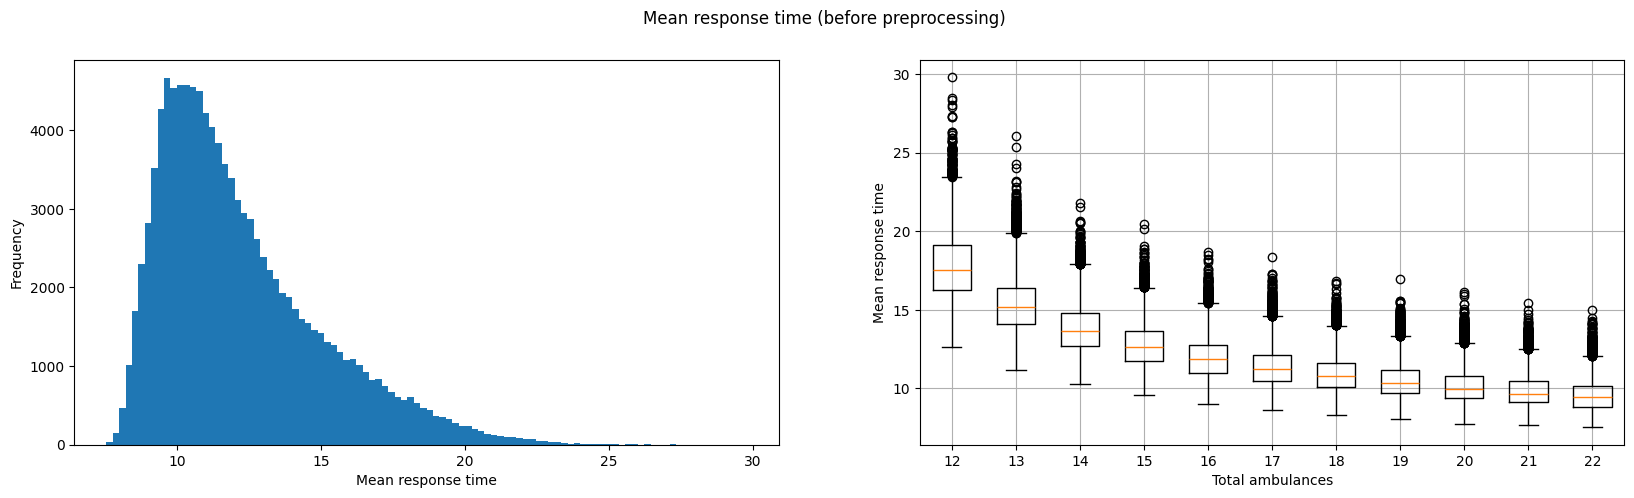

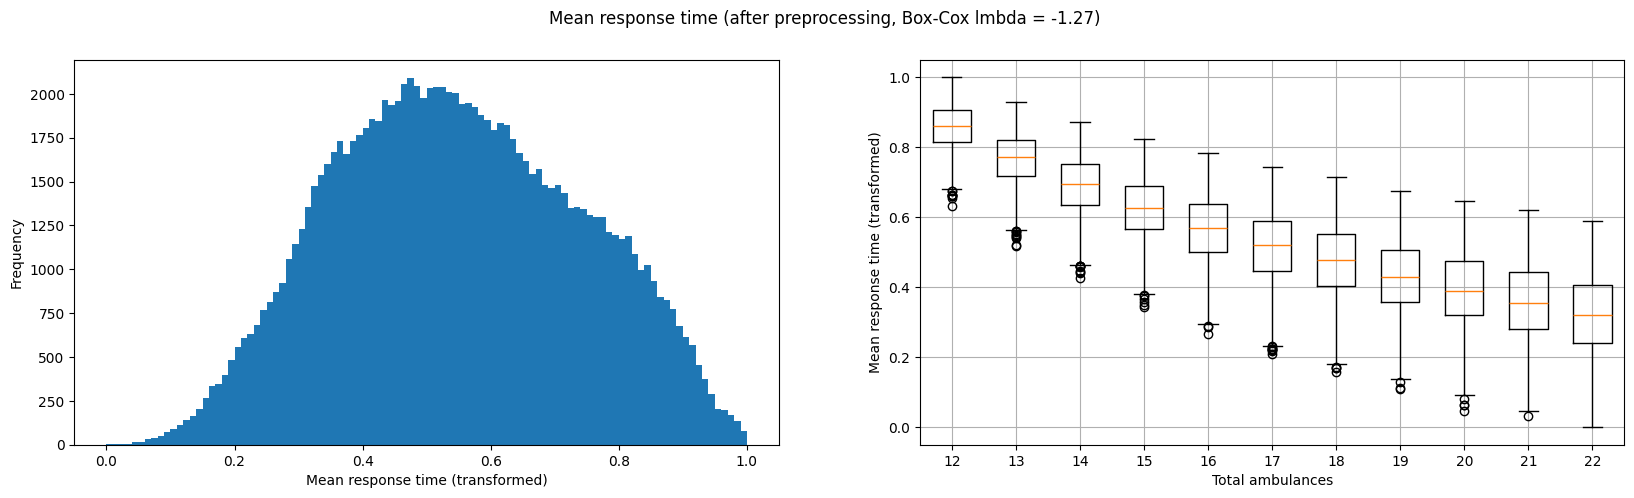

In [12]:
X = dataset.drop(columns=METRICS).to_numpy()
y = dataset.response_time_mean.to_numpy()
plot_metric(X, y, "Mean response time (before preprocessing)", "Mean response time")

X, y = remove_outliers_at_each_ambulance_count(X, y)
y, lmbda = scipy.stats.boxcox(y)
y = rescale(y)
plot_metric(X, y, f"Mean response time (after preprocessing, Box-Cox lmbda = {lmbda:0.2f})", "Mean response time (transformed)")

In [13]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[1000],
    name='simcoe_pmedian'
).to(device)
# Begin training with Adam and dropout
mlp.fit(X_pt, y_pt)
# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)
# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 69%|██████▉   | 69/100 [02:07<00:57,  1.85s/epoch, best_val_loss=0.000153, train_loss=0.000674, val_loss=0.000184]


Early stopping


 63%|██████▎   | 63/100 [01:58<01:09,  1.88s/epoch, best_val_loss=4.75e-5, train_loss=4.95e-5, val_loss=5.62e-5]


Early stopping


100%|██████████| 100/100 [02:45<00:00,  1.66s/epoch, best_val_loss=3.44e-5, train_loss=3.43e-5, val_loss=3.44e-5]


In [14]:
weights, biases = MLP.load_npz('simcoe_pmedian.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 600
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 4020 rows, 3036 columns and 26054 nonzeros
Model fingerprint: 0x3a758525
Variable types: 2019 continuous, 1017 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e-06, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e-04, 2e+01]
Found heuristic solution: objective 1.4454781
Presolve removed 26 rows and 27 columns
Presolve time: 0.09s
Presolved: 3994 rows, 3009 columns, 25847 nonzeros
Variable types: 1995 continuous, 1014 integer (997 binary)

Root relaxation: objective -4.213799e+00, 1835 iterations, 0.13 seconds (0.33 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.546128,0.837465,0.060000,8.241802,6.399122,15.832580,0.223799,20.567095
1,0.540271,0.832216,0.059826,8.285613,6.417939,16.017367,0.225853,20.592611
2,0.545999,0.829110,0.060094,8.341302,6.427924,16.288413,0.227370,20.721036
3,0.537794,0.829545,0.058937,8.404703,6.521696,16.130836,0.224039,20.560939
4,0.534382,0.824664,0.059011,8.442617,6.495653,16.390602,0.224505,20.644083


In [15]:
results.mean()

coverage_9min                     0.540915
coverage_15min                    0.830600
survival_rate                     0.059573
response_time_mean                8.343207
response_time_median              6.452467
response_time_90th_percentile    16.131960
busy_fraction                     0.225113
service_rate                     20.617153
dtype: float64